In [213]:
import os
import pandas as pd
import numpy as np

import csv
import glob

combined_data = {}

metric_targets = [ "inst_per_warp","dram_read_transactions", 
                  "gld_throughput", "l2_write_transactions",
                  "warp_nonpred_execution_efficiency",
                  "l2_tex_read_hit_rate","ipc",
                 "l2_tex_write_transactions","l2_read_transactions",
                 "inst_per_warp","shared_store_transactions",
                 "shared_load_transactions","gld_transactions","global_hit_rate",
                 "dram_write_throughput","tex_cache_throughput","l2_tex_read_throughput",
                 "l2_tex_write_throughput","l2_read_throughput","l2_write_throughput"]
bench_targets = [ "gaussian" ,"gemm" ]

for filen_ in glob.glob("/home/yzamora/power/nvidia_gpus/all_apps/gemm_results/*.csv"):
    
    filen = os.path.basename(filen_)
    
    filen_split = filen.split('.')[0].split('_')
    bench_name = filen_split[0]
    #metric_name = filen_split[1]
    #print(filen_split)
    size_str = filen_split[1].split('N')[1]
    
    #if not (metric_name in metric_targets): continue
    if not (bench_name in bench_targets): continue
    
    key_root = bench_name+"_"+size_str
    #print(key_root)
    
    # Now open the file and look for the data
    with open(filen_ ,'r') as file_handle:
        
        data_found = False
        ncols = 1
        fdata = csv.reader(file_handle)
        index_lookup = {}
        
        for line_split in fdata:
            print(line_split)
            lsplt = (len(line_split) > 0)

            if data_found:
                
                if lsplt and len(line_split) == ncols:
                    #percent - strip off end
                    # Get metric name here
                    mname_index = index_lookup['Metric Name']
                    metric_name = line_split[ mname_index ]
                    if not (metric_name in metric_targets): continue
                    
                    # Read in desired value for the current metric
                    target_index = index_lookup['Avg']; value = 0

                    # integer value
                    if metric_name in ["l2_tex_write_transactions","shared_store_transactions","shared_load_transactions",
                                      "gld_transactions","l2_read_transactions","l2_write_transactions","dram_read_transactions"]:
                        value = int(line_split[ target_index ])
                        
                    # Labeled with percentage
                    elif metric_name in [ "warp_nonpred_execution_efficiency","l2_tex_read_hit_rate","global_hit_rate" ]:
                        # Just take the first 7 chars and convert to fraction
                        value = float(line_split[ target_index ][0:7]) / 100.0
                        
                    # Labeled with bandwidth units
                    elif metric_name in [ "write", "read", "gld_throughput","dram_write_throughput","tex_cache_throughput",
                                        "l2_tex_read_throughput","l2_tex_write_throughput","l2_read_throughput","l2_write_throughput"]:
                        # Just take the first 
                        units = line_split[ target_index ][-4:-2]
                        mfact = 1.0
                        if   units == "KB": mfact = 1024
                        elif units == "MB": mfact = 1024*1024
                        elif units == "GB": mfact = 1024*1024*1024
                        value = float(line_split[ target_index ][0:7]) * mfact
                    
                    # otherwise, float
                    else:
                        value = float(line_split[ target_index ])
                    
                    # Parse name of kernel
                    kernel_name = line_split[ index_lookup['Kernel'] ].split('(')[0]
                    
                    # Define kernel-specific key
                    key = key_root + "_" + kernel_name
                    
                    # Initialize dict for this key, if it is new
                    if not (key in combined_data): 
                        combined_data [ key ] = {}
                        combined_data [ key ][ 'size' ] = int( size_str )
                    
                    # Store value for the metric being read right now
                    combined_data [ key ][ metric_name ] = value
                    
                else: data_found = False


            elif lsplt and line_split[0] == 'Device' and line_split[1] == 'Kernel':
                # Set flag that we are at the data:
                data_found = True
                # Set number of columns in table:
                ncols = len(line_split)
                # Generate an index lookup table:
                idx = 0
                for term in line_split:
                    index_lookup[term] = idx
                    idx += 1
                    
#print(combined_data)

[]
['cublasSgemm test result:']
[]
['running with min_m_k_n: 2 max_m_k_n: 16384 repeats: 10']
['==31333== NVPROF is profiling process 31333', ' command: ./gemm 128']
['allocating device variables']
['==31333== Some kernel(s) will be replayed on device 0 in order to collect all events/metrics.']
['float32: size 128 average: 1.47094 s ']
['==31333== Profiling application: ./gemm 128']
['==31333== Profiling result:']
['==31333== Metric result:']
['Device', 'Kernel', 'Invocations', 'Metric Name', 'Metric Description', 'Min', 'Max', 'Avg']
['Tesla P100-PCIE-16GB (0)', 'sgemm_32x32x32_NN_vec', '10', 'inst_per_warp', 'Instructions per warp', '1665.000000', '1665.000000', '1665.000000']
['Tesla P100-PCIE-16GB (0)', 'sgemm_32x32x32_NN_vec', '10', 'branch_efficiency', 'Branch Efficiency', '100.000000%', '100.000000%', '100.000000%']
['Tesla P100-PCIE-16GB (0)', 'sgemm_32x32x32_NN_vec', '10', 'warp_execution_efficiency', 'Warp Execution Efficiency', '100.000000%', '100.000000%', '100.000000%']
['

['==31589== Metric result:']
['Device', 'Kernel', 'Invocations', 'Metric Name', 'Metric Description', 'Min', 'Max', 'Avg']
['Tesla P100-PCIE-16GB (0)', 'sgemm_128x128x8_NN_vec', '10', 'inst_per_warp', 'Instructions per warp', '111014.000000', '111014.000000', '111014.000000']
['Tesla P100-PCIE-16GB (0)', 'sgemm_128x128x8_NN_vec', '10', 'branch_efficiency', 'Branch Efficiency', '100.000000%', '100.000000%', '100.000000%']
['Tesla P100-PCIE-16GB (0)', 'sgemm_128x128x8_NN_vec', '10', 'warp_execution_efficiency', 'Warp Execution Efficiency', '100.000000%', '100.000000%', '100.000000%']
['Tesla P100-PCIE-16GB (0)', 'sgemm_128x128x8_NN_vec', '10', 'warp_nonpred_execution_efficiency', 'Warp Non-Predicated Execution Efficiency', '99.057776%', '99.057776%', '99.057776%']
['Tesla P100-PCIE-16GB (0)', 'sgemm_128x128x8_NN_vec', '10', 'inst_replay_overhead', 'Instruction Replay Overhead', '0.000025', '0.000028', '0.000026']
['Tesla P100-PCIE-16GB (0)', 'sgemm_128x128x8_NN_vec', '10', 'shared_load_t

['Tesla P100-PCIE-16GB (0)', 'sgemm_128x128x8_NN_vec', '10', 'stall_other', 'Issue Stall Reasons (Other)', '18.724689%', '19.011200%', '18.858192%']
['Tesla P100-PCIE-16GB (0)', 'sgemm_128x128x8_NN_vec', '10', 'stall_constant_memory_dependency', 'Issue Stall Reasons (Immediate constant)', '0.008535%', '0.011622%', '0.008896%']
['Tesla P100-PCIE-16GB (0)', 'sgemm_128x128x8_NN_vec', '10', 'stall_pipe_busy', 'Issue Stall Reasons (Pipe Busy)', '0.445768%', '0.487560%', '0.462642%']
['Tesla P100-PCIE-16GB (0)', 'sgemm_128x128x8_NN_vec', '10', 'shared_efficiency', 'Shared Memory Efficiency', '44.677505%', '44.677505%', '44.677505%']
['Tesla P100-PCIE-16GB (0)', 'sgemm_128x128x8_NN_vec', '10', 'inst_fp_32', 'FP Instructions(Single)', '22346705920', '22346705920', '22346705920']
['Tesla P100-PCIE-16GB (0)', 'sgemm_128x128x8_NN_vec', '10', 'inst_fp_64', 'FP Instructions(Double)', '0', '0', '0']
['Tesla P100-PCIE-16GB (0)', 'sgemm_128x128x8_NN_vec', '10', 'inst_integer', 'Integer Instructions', 

['Tesla P100-PCIE-16GB (0)', 'sgemm_128x128x8_NN_vec', '10', 'local_load_transactions_per_request', 'Local Memory Load Transactions Per Request', '0.000000', '0.000000', '0.000000']
['Tesla P100-PCIE-16GB (0)', 'sgemm_128x128x8_NN_vec', '10', 'local_store_transactions_per_request', 'Local Memory Store Transactions Per Request', '0.000000', '0.000000', '0.000000']
['Tesla P100-PCIE-16GB (0)', 'sgemm_128x128x8_NN_vec', '10', 'gld_transactions_per_request', 'Global Load Transactions Per Request', '10.251716', '10.251716', '10.251716']
['Tesla P100-PCIE-16GB (0)', 'sgemm_128x128x8_NN_vec', '10', 'gst_transactions_per_request', 'Global Store Transactions Per Request', '4.000000', '4.000000', '4.000000']
['Tesla P100-PCIE-16GB (0)', 'sgemm_128x128x8_NN_vec', '10', 'shared_store_transactions', 'Shared Store Transactions', '44609600', '44609600', '44609600']
['Tesla P100-PCIE-16GB (0)', 'sgemm_128x128x8_NN_vec', '10', 'shared_load_transactions', 'Shared Load Transactions', '352172800', '352172

['Tesla P100-PCIE-16GB (0)', 'sgemm_128x128x8_NN_vec', '10', 'inst_compute_ld_st', 'Load/Store Instructions', '15638221824', '15638221824', '15638221824']
['Tesla P100-PCIE-16GB (0)', 'sgemm_128x128x8_NN_vec', '10', 'inst_misc', 'Misc Instructions', '1238317056', '1238317056', '1238317056']
['Tesla P100-PCIE-16GB (0)', 'sgemm_128x128x8_NN_vec', '10', 'inst_inter_thread_communication', 'Inter-Thread Instructions', '0', '0', '0']
['Tesla P100-PCIE-16GB (0)', 'sgemm_128x128x8_NN_vec', '10', 'issue_slots', 'Issue Slots', '6590017302', '6590019603', '6590018416']
['Tesla P100-PCIE-16GB (0)', 'sgemm_128x128x8_NN_vec', '10', 'cf_issued', 'Issued Control-Flow Instructions', '12746784', '12746784', '12746784']
['Tesla P100-PCIE-16GB (0)', 'sgemm_128x128x8_NN_vec', '10', 'cf_executed', 'Executed Control-Flow Instructions', '12746784', '12746784', '12746784']
['Tesla P100-PCIE-16GB (0)', 'sgemm_128x128x8_NN_vec', '10', 'ldst_issued', 'Issued Load/Store Instructions', '629213760', '629213760', '62

[]
['cublasSgemm test result:']
[]
['running with min_m_k_n: 2 max_m_k_n: 16384 repeats: 10']
['==604== NVPROF is profiling process 604', ' command: ./gemm 7552']
['allocating device variables']
['==604== Some kernel(s) will be replayed on device 0 in order to collect all events/metrics.']
['float32: size 7552 average: 63.4583 s ']
['==604== Profiling application: ./gemm 7552']
['==604== Profiling result:']
['==604== Metric result:']
['Device', 'Kernel', 'Invocations', 'Metric Name', 'Metric Description', 'Min', 'Max', 'Avg']
['Tesla P100-PCIE-16GB (0)', 'sgemm_128x128x8_NN_vec', '10', 'inst_per_warp', 'Instructions per warp', '542662.000000', '542662.000000', '542662.000000']
['Tesla P100-PCIE-16GB (0)', 'sgemm_128x128x8_NN_vec', '10', 'branch_efficiency', 'Branch Efficiency', '100.000000%', '100.000000%', '100.000000%']
['Tesla P100-PCIE-16GB (0)', 'sgemm_128x128x8_NN_vec', '10', 'warp_execution_efficiency', 'Warp Execution Efficiency', '100.000000%', '100.000000%', '100.000000%']
['

['Tesla P100-PCIE-16GB (0)', 'sgemm_128x128x8_NN_vec', '10', 'stall_texture', 'Issue Stall Reasons (Texture)', '0.000071%', '0.000129%', '0.000100%']
['Tesla P100-PCIE-16GB (0)', 'sgemm_128x128x8_NN_vec', '10', 'stall_sync', 'Issue Stall Reasons (Synchronization)', '13.531489%', '13.559472%', '13.547904%']
['Tesla P100-PCIE-16GB (0)', 'sgemm_128x128x8_NN_vec', '10', 'stall_other', 'Issue Stall Reasons (Other)', '19.347657%', '19.427208%', '19.373670%']
['Tesla P100-PCIE-16GB (0)', 'sgemm_128x128x8_NN_vec', '10', 'stall_constant_memory_dependency', 'Issue Stall Reasons (Immediate constant)', '0.000508%', '0.000682%', '0.000551%']
['Tesla P100-PCIE-16GB (0)', 'sgemm_128x128x8_NN_vec', '10', 'stall_pipe_busy', 'Issue Stall Reasons (Pipe Busy)', '0.413341%', '0.415183%', '0.414464%']
['Tesla P100-PCIE-16GB (0)', 'sgemm_128x128x8_NN_vec', '10', 'shared_efficiency', 'Shared Memory Efficiency', '44.515006%', '44.515006%', '44.515006%']
['Tesla P100-PCIE-16GB (0)', 'sgemm_128x128x8_NN_vec', '1

                                    size  inst_per_warp  \
gemm_10112_sgemm_128x128x8_NN_vec  10112  726342.000000   
gemm_10240_sgemm_128x128x8_NN_vec  10240  735526.000000   
gemm_1024_maxwell_sgemm_128x64_nn   1024   38856.096094   
gemm_10368_sgemm_128x128x8_NN_vec  10368  744710.000000   
gemm_1152_maxwell_sgemm_128x64_nn   1152   29509.467284   

                                   warp_nonpred_execution_efficiency  \
gemm_10112_sgemm_128x128x8_NN_vec                           0.991180   
gemm_10240_sgemm_128x128x8_NN_vec                           0.991181   
gemm_1024_maxwell_sgemm_128x64_nn                           0.995702   
gemm_10368_sgemm_128x128x8_NN_vec                           0.991183   
gemm_1152_maxwell_sgemm_128x64_nn                           0.994771   

                                   shared_store_transactions  \
gemm_10112_sgemm_128x128x8_NN_vec                  508466752   
gemm_10240_sgemm_128x128x8_NN_vec                  527974400   
gemm_1024_maxwell_sg

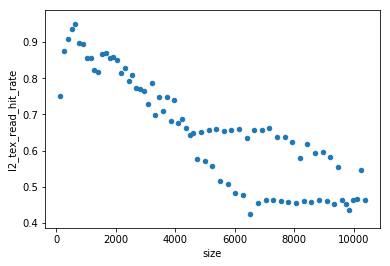

In [21]:
import pandas as pd
%matplotlib inline
df = pd.DataFrame.from_dict(combined_data,orient="index")
print (df.head())

df.plot(x='size', y='l2_tex_read_hit_rate', kind='scatter')

## Going through all metrics to check whether significant (not 0) --September 6, 2018

In [9]:
## Prepping files - Removing random data 
import re
import csv
import os
import glob

for filen_ in glob.glob("/home/yzamora/power/nvidia_gpus/all_apps/gaussian_results/*.csv"):
    cmd = "tr -cd \'\\11\\12\\15\\40-\\176\' < "+filen_ +" >"+ filen_+".temp"
    cmd2 = "mv " + filen_ + ".temp " + filen_
    os.system( cmd )
    os.system(cmd2)
#string = open("/home/yzamora/power/nvidia_gpus/all_apps/gaussian_results/gaussian_N1024.csv").read()
#new_str = re.sub('[^a-zA-Z0-9\n\.]', ' ', string)
#open('b.txt', 'w').write(new_str)

#txt_file = r"b.txt"
#csv_file = r"mycsv.csv"
#in_txt = csv.reader(open(txt_file,"r"),delimiter =' ')
#out_csv = csv.writer(open(csv_file, 'w'))
#out_csv.writerows(in_txt)

In [14]:
#Going through metrics
import numbers
combined_data_ = {}

metric_targets = []
all_sig_metrics = []
bench_targets = [ "gaussian" ,"gemm" ]
for filen_ in glob.glob("/home/yzamora/power/nvidia_gpus/all_apps/all_final_results/*.csv"):
#for filen_ in glob.glob("/home/yzamora/power/nvidia_gpus/all_apps/gaussian_results/*.csv"):
    filen = os.path.basename(filen_)
    #print (filen)
    filen_split = filen.split('.')[0].split('_')
    bench_name = filen_split[0]
    #metric_name = filen_split[1]
    #print(filen_split)
    size_str = filen_split[1].split('N')[1]
    
    #if not (metric_name in metric_targets): continue
    if not (bench_name in bench_targets): continue
    
    key_root = bench_name+"_"+size_str
    #print(key_root)
    levels = ["Idle", "Low","High", "Max"]
    bw_units = ["GB", "MB", "KB" ,"0B"]
    # Now open the file and look for the data
    with open(filen_ ,'r') as file_handle:
        #print (file_handle)
        data_found = False
        ncols = 1
        fdata = csv.reader(file_handle)
        index_lookup = {}
        #print(filen_)
        for line_split in fdata:
            #print (line_split)
            lsplt = (len(line_split) > 0)
      
            if data_found:
                #print("data found")
                if lsplt and len(line_split) == ncols:
                    #percent - strip off end
                    # Get metric name here
                    #mname_index = index_lookup['Metric Name']
                    #metric_name = line_split[ mname_index ]
                    #if not (metric_name in metric_targets): continue
                    
                    # Read in desired value for the current metric
                    target_index = index_lookup['Avg']; value = 0
                    metric_name = line_split[index_lookup['Metric Name']]
                    #print (line_split[target_index].isdecimal())
                    if line_split[target_index].isdecimal():
                        if line_split[target_index]!= '0':
                            #print(line_split[target_index])
                            all_sig_metrics.append(metric_name)
                            value = int(line_split[ target_index ])
                        
                        # Labeled with percentage
                    elif "%" == line_split[target_index][-1]:
                        #print ("percentage loop")
                        all_sig_metrics.append(metric_name)
                        value = float(line_split[ target_index ][0:7]) / 100.0
                        
                    # Labeled with bandwidth units
                    elif line_split[ target_index ][-4:-2] in bw_units:
                        # Just take the first 
                        units = line_split[ target_index ][-4:-2]
                        all_sig_metrics.append(metric_name)
                        mfact = 1.0
                        if   units == "KB": mfact = 1024
                        elif units == "MB": mfact = 1024*1024
                        elif units == "GB": mfact = 1024*1024*1024
                        elif units == "0B":  mfact = 1
                        value = float(line_split[ target_index ][0:7]) * mfact
                    
                    # idle, low, max
                    elif line_split[ target_index ][-1] == ")":
                        #print ("low")
                        all_sig_metrics.append(metric_name)
                        value = int(line_split[ target_index].split('(')[1].split(")")[0])
                        
                    # otherwise, float
                    #elif not(float(line_split[ target_index ]).is_integer()):
                    else:
                        #print(line_split[ target_index ].split('(')[0])
                        #print("in float")
                        #print(line_split[ target_index ].split('(')[0])
                        value = float(line_split[ target_index ])
                    
                    
                    
                    # Parse name of kernel
                    kernel_name = line_split[ index_lookup['Kernel'] ].split('(')[0]
                    
                    # Define kernel-specific key
                    key = key_root + "_" + kernel_name
                    
                    # Initialize dict for this key, if it is new
                    if not (key in combined_data_): 
                        combined_data_ [ key ] = {}
                        combined_data_ [ key ][ 'size' ] = int( size_str )
                        
                    # Store value for the metric being read right now
                    combined_data_ [ key ][ metric_name ] = value
                    
                else: data_found = False


            elif lsplt and line_split[0] == 'Device' and line_split[1] == 'Kernel':
                # Set flag that we are at the data:
                data_found = True
                # Set number of columns in table:
                ncols = len(line_split)
                # Generate an index lookup table:
                idx = 0
                for term in line_split:
                    index_lookup[term] = idx
                    idx += 1
                #print(index_lookup)
print(combined_data_)

{'gaussian_128_Fan2': {'size': 128, 'inst_per_warp': 28.519931, 'branch_efficiency': 1.0, 'warp_execution_efficiency': 0.487974, 'warp_nonpred_execution_efficiency': 0.47522, 'inst_replay_overhead': 0.037759, 'shared_load_transactions_per_request': 0.0, 'shared_store_transactions_per_request': 0.0, 'local_load_transactions_per_request': 0.0, 'local_store_transactions_per_request': 0.0, 'gld_transactions_per_request': 5.984674, 'gst_transactions_per_request': 8.39699, 'shared_store_transactions': 0, 'shared_load_transactions': 0, 'local_load_transactions': 0, 'local_store_transactions': 0, 'gld_transactions': 7191, 'gst_transactions': 3439, 'sysmem_read_transactions': 0, 'sysmem_write_transactions': 5, 'l2_read_transactions': 3398, 'l2_write_transactions': 3452, 'dram_read_transactions': 0, 'dram_write_transactions': 1, 'global_hit_rate': 0.538842, 'local_hit_rate': 0.0, 'gld_requested_throughput': 7447247805.48096, 'gst_requested_throughput': 4908127564.5952, 'gld_throughput': 50714114

                    size  inst_per_warp  branch_efficiency  \
gaussian_1024_Fan1  1024      33.151515           0.999903   
gaussian_1024_Fan2  1024      27.771998           1.000000   
gaussian_1152_Fan1  1152      27.809948           0.999916   
gaussian_1152_Fan2  1152      27.760276           1.000000   
gaussian_1280_Fan1  1280      29.516158           0.999929   

                    warp_execution_efficiency  \
gaussian_1024_Fan1                   0.977707   
gaussian_1024_Fan2                   0.498486   
gaussian_1152_Fan1                   0.982888   
gaussian_1152_Fan2                   0.498654   
gaussian_1280_Fan1                   0.983689   

                    warp_nonpred_execution_efficiency  inst_replay_overhead  \
gaussian_1024_Fan1                           0.950647              0.148229   
gaussian_1024_Fan2                           0.485504              0.000997   
gaussian_1152_Fan1                           0.958649              0.167938   
gaussian_1152_Fa

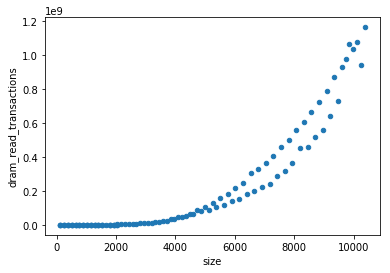

In [15]:
import pandas as pd
%matplotlib inline
df = pd.DataFrame.from_dict(combined_data_,orient="index")
print (df.head())

df.plot(x='size', y='dram_read_transactions', kind='scatter')


In [16]:
executable = "gaussian"
for file in glob.glob("/home/yzamora/power/nvidia_gpus/all_apps/gaussian_time_timing/gaussian_N128.csv"):
    #nf = "gaussian_N128.csv"
    nf = os.path.basename(file)
    filesplt = os.path.basename(nf).split(".")[0].split('N')[1]
    filename = executable + "_" + filesplt
    #print(filename)
    for key, value in combined_data_.items():
        #print(key)
        if filename in key:
            with open(file) as results:
                for l in results:
                    if "Time for CUDA kernel 1" in l:
                        #print("in kern")
                        combined_data_[key]["Time(s)"] = float(l.split(":")[1].split()[0])
                
#print(combined_data_)

In [17]:
#gemm_N128.csv
executable = "gemm_"
for file in glob.glob("/home/yzamora/power/nvidia_gpus/all_apps/gemm_timing/*.csv"):
    #print (file)
    filesplt = os.path.basename(file).split(".")[0].split('N')[1]
    filen = executable + filesplt +"_sge"
    #print(filen)
    for key, value in combined_data_.items():      
        if filen in key:
            with open(file) as results:
                for l in results:
                    if "average" in l:
                        combined_data_[key]["Time(s)"] = float(l.split(":")[2].split()[0])
#print(combined_data_)

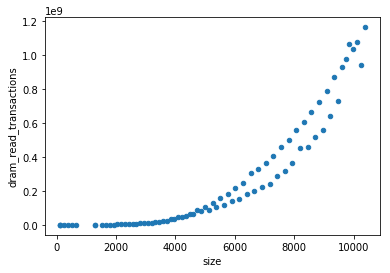

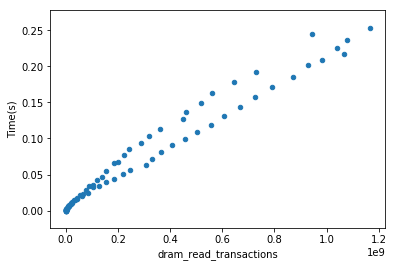

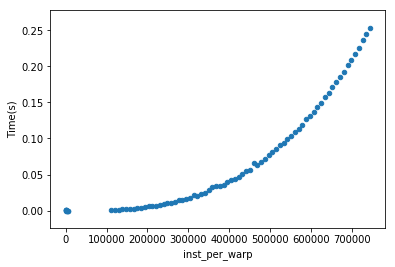

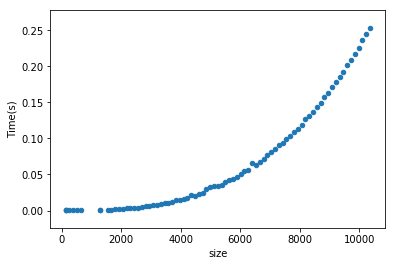

In [19]:
#Simple analysis of data
import pandas as pd
%matplotlib inline
df = pd.DataFrame.from_dict(combined_data_,orient="index")
df = df.dropna()
#print(df['Time(s)'])

#print (df.head())

df.plot(x='size', y='dram_read_transactions', kind='scatter')
df.plot(x='dram_read_transactions', y='Time(s)', kind='scatter')
df.plot(x='inst_per_warp', y='Time(s)', kind='scatter')
df.plot(x='size', y='Time(s)', kind='scatter')

In [20]:
import pandas as pd
%matplotlib inline


df = pd.DataFrame.from_dict(combined_data_,orient="index")
display(df.head())
#df["Time(s)"]

#df.plot(x='size', y='l2_tex_read_hit_rate', kind='scatter')

,size,inst_per_warp,branch_efficiency,warp_execution_efficiency,warp_nonpred_execution_efficiency,inst_replay_overhead,shared_load_transactions_per_request,shared_store_transactions_per_request,local_load_transactions_per_request,local_store_transactions_per_request,...,special_fu_utilization,half_precision_fu_utilization,single_precision_fu_utilization,double_precision_fu_utilization,flop_hp_efficiency,flop_sp_efficiency,flop_dp_efficiency,sysmem_read_utilization,sysmem_write_utilization,Time(s)
gaussian_1024_Fan1,1024,33.151515,0.999903,0.977707,0.950647,0.148229,0.0,0.0,0.0,0.0,...,1,0,1,0,0.0,0.000136,0.0,0,1,NaN
gaussian_1024_Fan2,1024,27.771998,1.000000,0.498486,0.485504,0.000997,0.0,0.0,0.0,0.0,...,0,0,1,0,0.0,0.000597,0.0,0,1,NaN
gaussian_1152_Fan1,1152,27.809948,0.999916,0.982888,0.958649,0.167938,0.0,0.0,0.0,0.0,...,1,0,1,0,0.0,0.000155,0.0,0,1,NaN
gaussian_1152_Fan2,1152,27.760276,1.000000,0.498654,0.485668,0.000805,0.0,0.0,0.0,0.0,...,0,0,1,0,0.0,0.000593,0.0,0,1,NaN
gaussian_1280_Fan1,1280,29.516158,0.999929,0.983689,0.958346,0.160987,0.0,0.0,0.0,0.0,...,1,0,1,0,0.0,0.000171,0.0,0,1,0.001306


# Further analysis of data - Random forest model, correlation graph, prediction graph

size                                     0.916940
inst_per_warp                            0.906545
branch_efficiency                        0.113325
warp_execution_efficiency                0.157615
warp_nonpred_execution_efficiency        0.169655
inst_replay_overhead                    -0.157851
shared_load_transactions_per_request     0.252511
shared_store_transactions_per_request   -0.050238
local_load_transactions_per_request           NaN
local_store_transactions_per_request          NaN
gld_transactions_per_request             0.046537
gst_transactions_per_request            -0.172365
shared_store_transactions                0.999885
shared_load_transactions                 0.999881
local_load_transactions                       NaN
local_store_transactions                      NaN
gld_transactions                         0.999879
gst_transactions                         0.987012
sysmem_read_transactions                      NaN
sysmem_write_transactions                     NaN


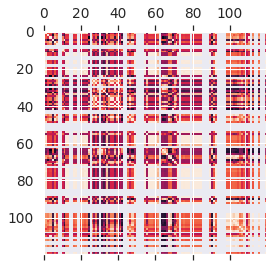

In [46]:
import matplotlib.pyplot as plt
plt.matshow(df.corr())
print(df.corr()["Time(s)"])

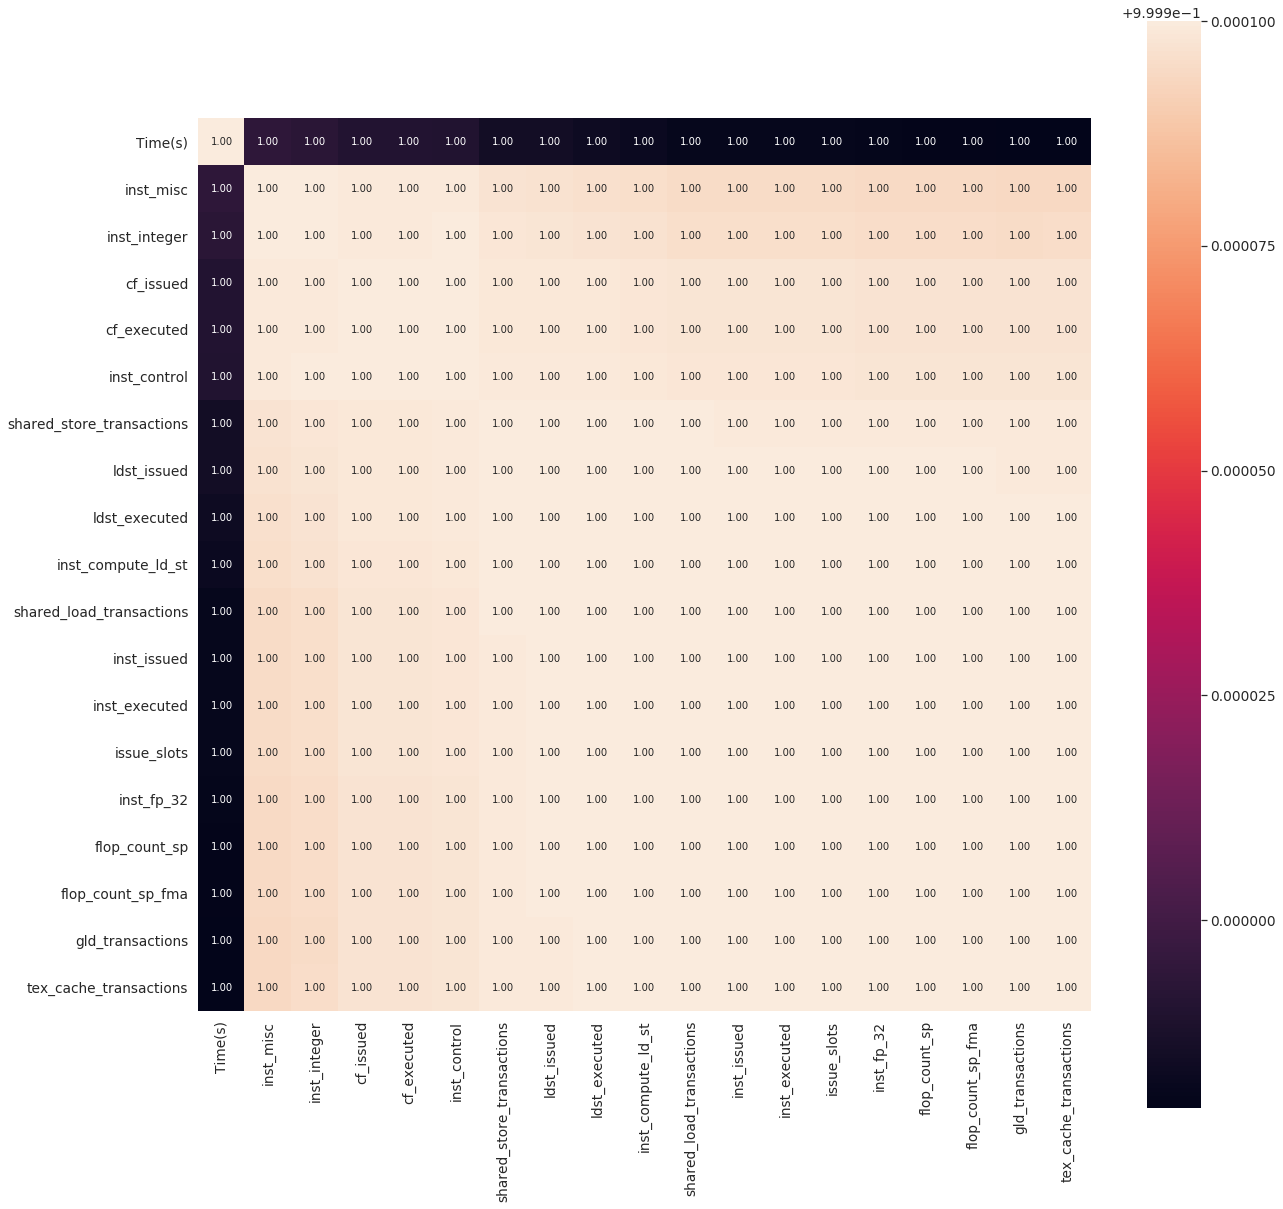

In [25]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import random
corrmat = df.corr()
k = 19
cols = corrmat.nlargest(k, "Time(s)")["Time(s)"].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.rcParams['figure.figsize'] = [20, 40]
plt.show()

In [26]:
import pandas as  pd
import numpy  as  np
import matplotlib.pyplot  as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
import scipy as sp
import pickle as pkl
%matplotlib inline

In [27]:
df = df.dropna()
X  =  df[['inst_per_warp','size','branch_efficiency','warp_execution_efficiency','warp_nonpred_execution_efficiency',
          'inst_replay_overhead','shared_load_transactions_per_request','shared_store_transactions_per_request','local_load_transactions_per_request',
          'local_store_transactions_per_request','special_fu_utilization','half_precision_fu_utilization','single_precision_fu_utilization','sysmem_write_utilization',
          'flop_sp_efficiency','double_precision_fu_utilization','flop_hp_efficiency','flop_dp_efficiency','sysmem_read_utilization']]
y = df['Time(s)']

print (df)
print ("X size:", X.shape)
print ('y size:', y.shape)

                                    size  inst_per_warp  branch_efficiency  \
gaussian_1280_Fan1                  1280      29.516158           0.999929   
gaussian_1280_Fan2                  1280      27.750902           1.000000   
gaussian_128_Fan1                    128      18.438976           0.999381   
gaussian_128_Fan2                    128      28.519931           1.000000   
gemm_10112_sgemm_128x128x8_NN_vec  10112  726342.000000           1.000000   
gemm_10240_sgemm_128x128x8_NN_vec  10240  735526.000000           1.000000   
gemm_10368_sgemm_128x128x8_NN_vec  10368  744710.000000           1.000000   
gemm_128_sgemm_32x32x32_NN_vec       128    1665.000000           1.000000   
gemm_1536_sgemm_128x128x8_NN_vec    1536  111014.000000           1.000000   
gemm_1664_sgemm_128x128x8_NN_vec    1664  120198.000000           1.000000   
gemm_1792_sgemm_128x128x8_NN_vec    1792  129382.000000           1.000000   
gemm_1920_sgemm_128x128x8_NN_vec    1920  138566.000000         

In [28]:
model = GridSearchCV(RandomForestRegressor(n_estimators=100),
                     param_grid=dict(max_features=range(5,18)),
                     scoring='neg_mean_squared_error',
                    cv=10)

In [29]:
model.fit(X,y)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': range(5, 18)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

Text(0,0.5,'RMSD')

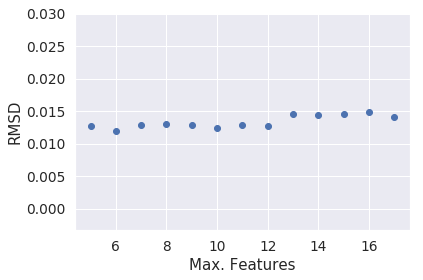

In [30]:
fig, ax = plt.subplots()
ax.scatter(model.cv_results_['param_max_features'].data,
          np.sqrt(-1 * model.cv_results_['mean_test_score']))
ax.set_xlabel('Max. Features')
ax.set_ylabel('RMSD')

In [31]:
model = model.best_estimator_


In [33]:
list(zip(X.columns,model.feature_importances_))

[('inst_per_warp', 0.22297887253428328),
 ('size', 0.237136826247879),
 ('branch_efficiency', 2.6856045031349414e-08),
 ('warp_execution_efficiency', 7.167723934525522e-05),
 ('warp_nonpred_execution_efficiency', 0.20893302061979402),
 ('inst_replay_overhead', 0.049540927681049396),
 ('shared_load_transactions_per_request', 0.19427700955430574),
 ('shared_store_transactions_per_request', 0.06348694039327625),
 ('local_load_transactions_per_request', 0.0),
 ('local_store_transactions_per_request', 0.0),
 ('special_fu_utilization', 2.3135572890670525e-06),
 ('half_precision_fu_utilization', 0.0),
 ('single_precision_fu_utilization', 0.0018114404540346893),
 ('sysmem_write_utilization', 0.0),
 ('flop_sp_efficiency', 0.02176094486269835),
 ('double_precision_fu_utilization', 0.0),
 ('flop_hp_efficiency', 0.0),
 ('flop_dp_efficiency', 0.0),
 ('sysmem_read_utilization', 0.0)]

In [34]:
all_y_test = np.zeros((0,))
all_y_pred = np.zeros((0,))
#given options and list of data, returns the indices of training and test sets 
for train_inds, test_inds in ShuffleSplit(n_splits=5, test_size=0.1).split(X,y):
    # Split off the train and test set
    X_test, y_test = X.iloc[test_inds, :], y[test_inds]
    X_train, y_train = X.iloc[train_inds, :], y[train_inds]
    
    # Train the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Append the results
    all_y_test = np.concatenate((all_y_test, y_test))
    #print (all_y_test)
    all_y_pred = np.concatenate((all_y_pred, y_pred))

In [35]:

print ("R:",  sp.stats.pearsonr(all_y_test, all_y_pred)[0])
print ("MAE:", np.abs(all_y_test - all_y_pred).mean(), 's')
print ("RMSE:", np.sqrt(np.power(all_y_test - all_y_pred, 2).mean()), 's')

R: 0.9989101301619862
MAE: 0.0018330038060617247 s
RMSE: 0.002809916621973662 s


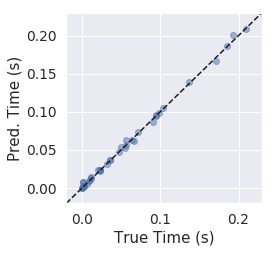

In [37]:
fig, ax = plt.subplots()

# Make the plot
ax.scatter(all_y_test, all_y_pred, alpha=0.5)

# Make it pretty
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_xlim())

ax.set_xlabel('True Time (s)')
ax.set_ylabel('Pred. Time (s)')

fig.set_size_inches(3.5, 3.5)

# Add in the goal line
ax.plot(ax.get_xlim(), ax.get_ylim(), 'k--');